# Ensemble Learning - Meta Models
Combine base models to meta models

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
from ast import literal_eval

import pickle

from sklearn import metrics
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from collections import Counter

pd.set_option("display.max_columns", None)

## Data Import & Data Preparation

In [4]:
DATA_PATH = "./data"
MODEL_PATH = f"{DATA_PATH}/BaseLearner"
EXPORT_PATH = f"{DATA_PATH}/MetaLearner"

SPECIES = {
    "1":"Deciduous",
    "2":"Conifer",
    "1 2":"Mixed"
}

SPECIES_inverse = {
    "Deciduous": "1",
    "Conifer": "2",
    "Mixed": "1 2"
}

In [5]:
df = pd.read_csv(f"{DATA_PATH}/location_cluster.csv")

df = df.sort_values(by="year")

# -----

def is_healthy(damage_class_group:str)->int:
    if damage_class_group == "healthy":
        return 1
    else:
        return 0
    
def is_damaged(damage_class_group:str)->int:
    if damage_class_group == "damaged":
        return 1
    else:
        return 0
    
def is_dead(damage_class_group:str)->int:
    if damage_class_group == "dead":
        return 1
    else:
        return 0
    
df["is_healthy"] = df["damage_class_group"].apply(lambda x: is_healthy(x))
df["is_damaged"] = df["damage_class_group"].apply(lambda x: is_damaged(x))
df["is_dead"] = df["damage_class_group"].apply(lambda x: is_dead(x))

# -----

static_cols = [
    col for col in df.columns if "location_cluster_" in col
]
static_cols.append("tree_1")

vegetation_cols = [
    col for col in df.columns if (("ndvi" in col) or ("evi2" in col)) and not col.endswith('max')
]

weather_cols = [
    'autumn_humidity',
    'autumn_rain_mm',
    'autumn_sun_h',
    'extreme_heat_day',
    'frozen_day',
    'heat_day',
    'heavy_rain',
    'spring_humidity',
    'spring_rain_mm',
    'spring_sun_h',
    'storm',
    'summer_humidity',
    'summer_longest_heat_wave',
    'summer_periods_without_rain_summer',
    'summer_rain_mm',
    'summer_sun_h',
    'winter_humidity',
    'winter_longest_cold_wave',
    'winter_rain_mm',
    'winter_snow_cm',
    'winter_sun_h',
]

all_features = static_cols + vegetation_cols + weather_cols

df[all_features].head()

,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,location_cluster_8,location_cluster_9,location_cluster_10,location_cluster_11,location_cluster_12,location_cluster_13,tree_1,evi2,evi2-1,evi2_diff,evi2_max_diff,evi2_raster,evi2_raster-1,evi2_raster_diff,evi2_vegetation_raster,evi2_vegetation_raster-1,evi2_vegetation_raster_diff,ndvi,ndvi-1,ndvi_diff,ndvi_max_diff,ndvi_raster,ndvi_raster-1,ndvi_raster_diff,ndvi_vegetation_raster,ndvi_vegetation_raster-1,ndvi_vegetation_raster_diff,autumn_humidity,autumn_rain_mm,autumn_sun_h,extreme_heat_day,frozen_day,heat_day,heavy_rain,spring_humidity,spring_rain_mm,spring_sun_h,storm,summer_humidity,summer_longest_heat_wave,summer_periods_without_rain_summer,summer_rain_mm,summer_sun_h,winter_humidity,winter_longest_cold_wave,winter_rain_mm,winter_snow_cm,winter_sun_h
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.780422,0.247127,0.134649,-0.063166,0.558887,-1.965227,2.321263,2.190397,-1.591913,1.467303,2.389869,0.269184,0.155518,-0.056732,0.396759,-2.000923,2.376153,4.699451,-1.625971,1.476802,3.188868,2.349058,-0.032661,-0.510027,-0.844847,0.729139,1.259041,0.020538,0.030137,-0.308301,0.671584,-1.489254,0.595120,0.671331,1.252978,0.111377,-0.265597,1.79314,0.343276,-1.081905,0.637993,-0.509518
5188,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.377409,0.134649,1.210990,1.661654,-1.010216,0.702443,0.638921,-0.897612,0.639956,0.116478,-1.394638,0.155518,1.023457,1.773875,-1.020630,0.601524,-0.686361,-0.906359,0.610358,-1.136011,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934
5187,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.606661,0.134649,1.546983,1.771145,-1.010216,0.702443,0.372483,-0.897612,0.639956,-0.247533,-1.639614,0.155518,1.352077,1.909480,-1.020630,0.601524,-1.216333,-0.906359,0.610358,-1.472954,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934
5186,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.074025,0.134649,0.871901,1.478956,-1.010216,0.702443,0.858797,-0.897612,0.639956,0.449890,-1.072860,0.155518,0.711611,1.542268,-1.020630,0.601524,-0.168402,-0.906359,0.610358,-0.695910,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934
5185,0,0,0,1,0,0,0,0,0,0,0,0,0,0,-0.630696,-1.332807,0.134649,1.155192,1.658395,-1.010216,0.702443,0.678140,-0.897612,0.639956,0.173522,-1.347134,0.155518,0.970864,1.763622,-1.020630,0.601524,-0.600060,-0.906359,0.610358,-1.071161,1.391816,0.207266,-0.081468,1.680325,-0.857075,1.889191,0.691020,-0.369506,0.323830,0.515489,0.852785,-0.814671,0.897376,0.046127,-0.719613,-0.140728,0.69179,-0.815622,0.119561,-0.193376,-1.501934


### Define Functions

In [6]:
import itertools
import pprint
sns.set(style="ticks")

def tune_threshold(actual, pred_proba, axes):
    # Array for finding the optimal threshold
    thresholds = np.arange(0.0, 1.0, 0.001)
    fscore = np.zeros(shape=(len(thresholds)))
    # Fit the model
    def to_labels(pos_probs, threshold):
         return (pos_probs >= threshold).astype('int')
    fscore = [metrics.f1_score(actual, to_labels(pred_proba, t)) for t in thresholds]
        
    # Find the optimal threshold
    ix = np.argmax(fscore)
    if axes:
        sns.lineplot(thresholds, fscore, color="black", ax=axes, err_style=None)
        sns.scatterplot([thresholds[ix]], [fscore[ix]], marker='^', color='tab:red', label=f'Optimal threshold @ {thresholds[ix]:.3f}', s=150, zorder=2, ax=axes)

    return thresholds[ix], fscore[ix]

def apply_prediction(pos_probs, threshold):
     return (pos_probs >= threshold).astype('int')
    
def parse_results(data_frame:pd.DataFrame):
    param_cols = [col for col in data_frame.columns if col.startswith("params")]
    metric_cols = [col for col in data_frame.columns if col.startswith("metrics")]
    feat_permutation_cols = [col for col in data_frame.columns if col.startswith("feature_permutaion_importance")]
    
    param_cols.extend(["model", "target", "species"])
    metric_cols.extend(["model", "target", "species"])
    feat_permutation_cols.extend(["model", "target", "species"])
    
    metric_groups = ["roc", "prc", "tuning"]
    actual_metrics = ["threshold", "cohen_kappa", "f1", "recall", "precision", "tn", "fp", "fn", "tp"]

    metrics_values = []
    for metric_group in metric_groups:
        for _i, _r in data_frame.iterrows():
            vals = {"group": metric_group, "model": _r["model"], "target": _r["target"], "species": _r["species"], "auc": _r["metrics.auc"]}
            for col in metric_cols:
                for _m in actual_metrics:
                    if _m in col and metric_group in col:
                        vals[_m] = _r[col]

            metrics_values.append(vals)

    df_metrics = pd.json_normalize(metrics_values)
    df_metrics = df_metrics.sort_values(by="f1", ascending=False)

    best_model_selection = list()
    for _i, _r in df_metrics.groupby(["target", "species", "model"]).size().reset_index().iterrows():
        df_filter = df_metrics.loc[(df_metrics.target == _r.target) & (df_metrics.species == _r.species) & (df_metrics.model == _r.model)].sort_values(by="threshold", ascending=False)
        best_model_selection.append(df_filter.loc[df_filter.cohen_kappa == df_filter.cohen_kappa.max()].iloc[0][["target", "species", "model", "group"]].values)

    df_model_selection = pd.DataFrame(data=best_model_selection, columns=["target", "species", "model", "group"])
    df_best_metrics = df_metrics.merge(df_model_selection, on=["target", "species", "model", "group"], how="inner").drop_duplicates()
    
    df_parameter = data_frame[param_cols].melt(id_vars=param_cols[-4:], var_name="param", value_name="val")
    df_parameter["param"] = df_parameter["param"].apply(lambda x: x.replace("params.", ""))
    df_parameter = df_parameter.dropna()

    df_feature_importance = data_frame[feat_permutation_cols].melt(id_vars=feat_permutation_cols[-4:], var_name="feature", value_name="feature_importance")
    df_feature_importance["feature"] = df_feature_importance["feature"].apply(lambda x: x.replace("feature_permutaion_importance.", ""))
    df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False)
    
    df_features = data_frame.copy()
    df_features["relevant_features"] = df_features["relevant_features"].apply(lambda x: x.replace("\'", "").strip('][').split(', '))
    df_features = df_features[["model", "target", "species", "relevant_features"]]
    
    return df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance


def find_outliers(data_frame: pd.DataFrame, species: str, N_ITEMS: int=5):
    max_diff = list()
    max_year_diff = list()
    max_year_diff_in_order = list()

    # get yearly changes by observation's sat
    wze_damage_class_change = data_frame.loc[(data_frame["aoi"] == "blackforest") & (data_frame["list_tree_sp_cat_ids"] == species)]
    wze_damage_class_change = wze_damage_class_change.groupby(["year", "observation_id", "sat"]).agg({"damage_class": "median"}).reset_index()
    wze_damage_class_change = wze_damage_class_change.loc[wze_damage_class_change["year"] >= 2015]

    # round damage_class change
    wze_damage_class_change["damage_class"] = np.ceil(wze_damage_class_change["damage_class"])

    # build pivot for observarion sat
    wze_damage_class_sat_change_pivot = wze_damage_class_change.pivot(columns=["year"], index=["observation_id", "sat"], values="damage_class")

    # changes by observation sat
    for _index, _observation in wze_damage_class_sat_change_pivot.iterrows():
        # combine each item with each
        cross_diff = np.array([abs(diff[0]) for diff in np.diff(np.array(list(itertools.combinations(_observation.values, 2))))])
        # year diff in order
        ordered_diff = np.array([abs(diff) for diff in np.diff(np.array(list(_observation.values)))])
        if len(cross_diff) > 0:
            max_year_diff.append([_index[0], _index[1], np.nanmax(cross_diff)])
        if len(ordered_diff) > 0:
            max_year_diff_in_order.append([_index[0], _index[1], np.nanmax(ordered_diff)])

    df_max_year_diff = pd.DataFrame(data=max_year_diff, columns=["observation_id", "sat", "max_diff"])
    df_max_year_diff = df_max_year_diff.dropna()
    df_max_year_diff = df_max_year_diff.sort_values(by="max_diff", ascending=False)

    df_max_year_diff_in_order = pd.DataFrame(data=max_year_diff_in_order, columns=["observation_id", "sat", "max_diff"])
    df_max_year_diff_in_order = df_max_year_diff_in_order.dropna()
    df_max_year_diff_in_order = df_max_year_diff_in_order.sort_values(by="max_diff", ascending=False)

    # get max diff between sats by observation
    for _observation in wze_damage_class_sat_change_pivot.reset_index()["observation_id"].unique():
        for year in list(wze_damage_class_sat_change_pivot.loc[_observation].columns):
            cross_diff = np.array([abs(diff[0]) for diff in np.diff(np.array(list(itertools.combinations(wze_damage_class_sat_change_pivot.loc[_observation][year].values, 2))))])
            if len(cross_diff) > 0:
                max_diff.append([_observation, year, np.nanmax(cross_diff)])

    df_max_diff = pd.DataFrame(data=max_diff, columns=["observation_id", "year", "max_diff"])
    df_max_diff = df_max_diff.dropna()
    df_max_diff = df_max_diff.sort_values(by="max_diff", ascending=False)

    # set observation_ids
    test_observations = list()
    test_observations_desc = dict()

    test_observations_desc["innerhalb Observierung / Sat"] = [list(df_max_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)]
    test_observations_desc["innerhalb Observierung / Jahr"] = [list(df_max_year_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)]
    test_observations_desc["innerhalb Observierung / Jahr (chronologisch)"] = [list(df_max_year_diff_in_order["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)]

    test_observations.extend([
        [list(df_max_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)],
        [list(df_max_year_diff["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)],
        [list(df_max_year_diff_in_order["observation_id"].unique())[i] for i in range(0, N_ITEMS*2, 2)],
    ])
    test_observations = np.array(test_observations).flatten()
    test_observations = np.unique(np.array(test_observations))

    pprint.pprint(test_observations_desc)

    return test_observations


def train_test_split_by_observation(data_frame:pd.DataFrame, target:str, features:list, species:str):
    # observation id + year to prevent splitted observation in training and test data
    data_frame["key"] = data_frame["observation_id"] + ":" + data_frame["year"].astype(str)
    
    # group by observation_id and year to get unique observations by year only to prevent overfitting
    df_group = data_frame.groupby(["observation_id", "year"]).agg({"damage_class_group": lambda x: x.value_counts().index[0], target: lambda x: x.value_counts().index[0], "aoi": "first"}).reset_index()
    # remove all damaged classes that are not in BF
    df_group = df_group.loc[~((df_group.damage_class_group == "damaged") & (df_group.aoi != "blackforest"))]
    
    y_observation_id = df_group.pop(target)
    X_observation_id = df_group

    # key to identify splitted data
    X_observation_id["key"] = X_observation_id["observation_id"] + ":" + X_observation_id["year"].astype(str)
    # train test split
    X_train_observation_id, X_test_observation_id, y_train_observation_id, y_test_observation_id = train_test_split(X_observation_id, y_observation_id, train_size=0.9, stratify=y_observation_id, random_state=2022)

    # filter for train test samples based on observation:year
    _X_train = data_frame.loc[data_frame["key"].isin(list(X_train_observation_id.key))][features]
    _X_test = data_frame.loc[data_frame["key"].isin(list(X_test_observation_id.key))][features]
    
    if species == "1":
        _group_ids = data_frame.loc[(data_frame["damage_class_group"] == "damaged") & (data_frame["aoi"] != "blackforest")].groupby(["observation_id", "year"]).agg({"damage_class_group": lambda x: x.value_counts().index[0], target: lambda x: x.value_counts().index[0], "aoi": "first"}).reset_index()["observation_id"].unique()
        _X_train = pd.concat([_X_train, data_frame.loc[data_frame["observation_id"].isin(_group_ids)]], ignore_index=True)
        
    return _X_train, _X_test


### Set Hold-Out

In [7]:
np.random.seed(2022)

data = dict()
for species in ["1", "2", "1 2"]:
    print(f"train test validation split for {SPECIES[species]}...")
    _binned = df.copy()

    _binned = _binned.loc[_binned["list_tree_sp_cat_ids"] == species]

    for col in all_features:
        _binned[col] = pd.cut(_binned[col], 10)
        _binned[col] =_binned[col].cat.codes

    min_max_scaler = MinMaxScaler()
    _binned[all_features] = min_max_scaler.fit_transform(_binned[all_features])

    validation_observation_ids = find_outliers(data_frame=df, species=species, N_ITEMS=3)
    _validation = _binned.loc[_binned.observation_id.isin(validation_observation_ids)]
    
    _train, _test = train_test_split_by_observation(data_frame=_binned.loc[~_binned.observation_id.isin(validation_observation_ids)], target="damage_class_group", features=_binned.columns, species=species)
    _test = pd.concat([_test, _validation])
    
    print(f"->\ttrain: {_train.shape} test: {_test.shape} val: {_validation.shape}")
    print()
    
    splitted_data = {
        'train': _train,
        'test': _test,
        'validation': _validation
    }
    
    data[species] = splitted_data

train test validation split for Deciduous...
{'innerhalb Observierung / Jahr': ['BW_439', 'BW_639', 'BW_108'],
 'innerhalb Observierung / Jahr (chronologisch)': ['BW_755',
                                                   'BW_108',
                                                   'BW_9812'],
 'innerhalb Observierung / Sat': ['BW_276', 'BW_439', 'BW_755']}
->	train: (4483, 74) test: (541, 73) val: (476, 73)

train test validation split for Conifer...
{'innerhalb Observierung / Jahr': ['BW_waldshut', 'BW_589', 'BW_511'],
 'innerhalb Observierung / Jahr (chronologisch)': ['BW_waldshut',
                                                   'BW_589',
                                                   'BW_508'],
 'innerhalb Observierung / Sat': ['BW_9818', 'BW_421', 'BW_500']}
->	train: (6563, 73) test: (1480, 73) val: (760, 73)

train test validation split for Mixed...
{'innerhalb Observierung / Jahr': ['BW_199', 'BW_283', 'BW_639'],
 'innerhalb Observierung / Jahr (chronologisch)': ['BW_1

## Meta Learner
The following steps are performed for all damage classes:
1) Loading the results of the base models
2) Training of the best base models with training data
3) Simple weighted majority decision with Cohen's Kappa as weighting
4) Form metrics for test data set
4) Validate models with validation dataset

### Damaged vegetation

In [8]:
df_metrics_damaged = list()
df_best_metrics_damaged = list()
df_parameter_damaged = list()
df_features_damaged = list()
df_feature_importance_damaged = list()

for version in ["v1", "v5"]:
    df_results = pd.read_csv(f"{MODEL_PATH}/{version}/modelling_pipeline_results.csv")
    df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance = parse_results(df_results)
    df_metrics["source"] = version
    df_best_metrics["source"] = version
    df_parameter["source"] = version
    df_features["source"] = version
    df_feature_importance["source"] = version

    df_metrics_damaged.append(df_metrics)
    df_best_metrics_damaged.append(df_best_metrics)
    df_parameter_damaged.append(df_parameter)
    df_features_damaged.append(df_features)
    df_feature_importance_damaged.append(df_feature_importance)
       
df_metrics_damaged = pd.concat(df_metrics_damaged, ignore_index=True)
df_best_metrics_damaged = pd.concat(df_best_metrics_damaged, ignore_index=True)
df_parameter_damaged = pd.concat(df_parameter_damaged, ignore_index=True)
df_features_damaged = pd.concat(df_features_damaged, ignore_index=True)
df_feature_importance_damaged = pd.concat(df_feature_importance_damaged, ignore_index=True)

df_metrics_damaged.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).groupby(["species", "model"]).first()

group      target       auc  \
species   model                                                          
Conifer   AdaBoostClassifier              tuning  is_damaged  0.822033   
          BalancedRandomForestClassifier     prc  is_damaged  0.832218   
          DecisionTreeClassifier          tuning  is_damaged  0.735362   
          HistGradientBoostingClassifier  tuning  is_damaged  0.819971   
          KNeighborsClassifier               prc  is_damaged  0.787342   
          RUSBoostClassifier              tuning  is_damaged  0.748870   
          RandomForestClassifier             prc  is_damaged  0.814057   
          SVM                             tuning  is_damaged  0.768723   
          XGBClassifier                   tuning  is_damaged  0.842335   
Deciduous AdaBoostClassifier                 prc  is_damaged  0.702559   
          BalancedRandomForestClassifier     prc  is_damaged  0.666885   
          DecisionTreeClassifier          tuning  is_damaged  0.584819   
          HistGradientBoostingClassifier  tuning  is_damaged  0.747019   
          KNeighborsClassifier               roc  is_damaged  0.624208   
          RUSBoostClassifier              tuning  is_damaged  0.603256   
          RandomForestClassifier             prc  is_damaged  0.760657   
          SVM                                roc  is_damaged  0.652872   
          XGBClassifier                   tuning  is_damaged  0.800000   
Mixed     AdaBoostClassifier                 prc  is_damaged  0.789066   
          BalancedRandomForestClassifier     roc  is_damaged  0.778817   
          DecisionTreeClassifier             roc  is_damaged  0.628162   
          HistGradientBoostingClassifier  tuning  is_damaged  0.839361   
          KNeighborsClassifier               roc  is_damaged  0.681480   
          RUSBoostClassifier                 prc  is_damaged  0.812994   
          RandomForestClassifier             roc  is_damaged  0.819742   
          SVM                                roc  is_damaged  0.788410   
          XGBClassifier                      roc  is_damaged  0.794206   

                                          threshold  cohen_kappa        f1  \
species   model                                                              
Conifer   AdaBoostClassifier               0.500000     0.387354  0.943288   
          BalancedRandomForestClassifier   0.407720     0.484601  0.943737   
          DecisionTreeClassifier           0.428000     0.421356  0.942565   
          HistGradientBoostingClassifier   0.569000     0.525212  0.953080   
          KNeighborsClassifier             0.570310     0.364643  0.937074   
          RUSBoostClassifier               0.486000     0.365151  0.939734   
          RandomForestClassifier           0.586779     0.551416  0.953611   
          SVM                              0.533000     0.363855  0.943553   
          XGBClassifier                    0.399000     0.472163  0.947837   
Deciduous AdaBoostClassifier               0.491952     0.434160  0.945547   
          BalancedRandomForestClassifier   0.415191     0.373500  0.939980   
          DecisionTreeClassifier           0.445000     0.178185  0.936847   
          HistGradientBoostingClassifier   0.771000     0.465890  0.948601   
          KNeighborsClassifier             0.835333     0.112985  0.737901   
          RUSBoostClassifier               0.478000     0.336541  0.943775   
          RandomForestClassifier           0.602051     0.333566  0.944361   
          SVM                              0.431184     0.170072  0.830080   
          XGBClassifier                    0.624000     0.619309  0.957513   
Mixed     AdaBoostClassifier               0.500144     0.297043  0.949598   
          BalancedRandomForestClassifier   0.495115     0.360535  0.902117   
          DecisionTreeClassifier           0.492373     0.129225  0.825503   
          HistGradientBoostingClassifier   0.616000     0.397225  0.953711   
          KNeighborsClas

#### Build Meta-Model

In [ ]:
df_best_damaged_models_by_species = df_metrics_damaged.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).sort_values(by="cohen_kappa", ascending=False)

_target = "is_damaged"
damaged_estimators = dict()

for species in df_best_damaged_models_by_species["species"].unique():
    damaged_estimators[species] = list()
    
    # get best 5 models (according to cohen kappa)
    for _i, row_best_model in df_best_damaged_models_by_species.loc[df_best_damaged_models_by_species["species"] == species].iloc[:].iterrows():
        model_dict = dict()
        
        # get model with predefined hyper parameters
        _model = clone(pickle.load(open(f"{MODEL_PATH}/{row_best_model['source']}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'rb')))
        
        # get relevant features
        _relevant_features = df_features_damaged.loc[(df_features_damaged["species"] == species) & (df_features_damaged["model"] == row_best_model["model"]) & (df_features_damaged["source"] == row_best_model["source"])].iloc[0]["relevant_features"]
        
        # Train Data Check
        if row_best_model["source"] == "v5": # balance data
            num_cols = [col for col in data[SPECIES_inverse[species]]["train"].columns if (data[SPECIES_inverse[species]]["train"][col].dtype != object)]
            sampling_strategy_over_sample = {
                "healthy": dict(Counter(data[SPECIES_inverse[species]]["train"]["damage_class_group"]))["healthy"],
                "damaged": dict(Counter(data[SPECIES_inverse[species]]["train"]["damage_class_group"]))["damaged"],
                "dead": dict(Counter(data[SPECIES_inverse[species]]["train"]["damage_class_group"]))["healthy"]
            }
            sampler = SMOTEENN(sampling_strategy=sampling_strategy_over_sample, smote=SMOTE(random_state=2022, k_neighbors=6, sampling_strategy=sampling_strategy_over_sample), enn=EditedNearestNeighbours(n_neighbors=5, kind_sel="mode", n_jobs=58), random_state=2022, n_jobs=58)
            X_resampled, y_resampled = sampler.fit_resample(X=data[SPECIES_inverse[species]]["train"][num_cols], y=data[SPECIES_inverse[species]]["train"]["damage_class_group"])

            # over sample (TARGET WILL BECOME TWICE NUMBERS)
            sampling_strategy_under_sample = {
                "healthy": dict(Counter(y_resampled))["healthy"],
                "damaged": dict(Counter(y_resampled))["healthy"],
                "dead": dict(Counter(y_resampled))["dead"]
            }
            under_sampler = RandomUnderSampler(random_state=2022, sampling_strategy=sampling_strategy_under_sample)
            X_resampled, y_resampled = under_sampler.fit_resample(X=X_resampled[num_cols], y=y_resampled)
            
            # TRAINING DATA
            X_train = X_resampled[_relevant_features]
            y_train = X_resampled[_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
        else: # v1, v2 --> keep as it is
            # TRAINING DATA
            X_train = data[SPECIES_inverse[species]]["train"][_relevant_features]
            y_train = data[SPECIES_inverse[species]]["train"][_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
            
        # best practices from Jason Brownlee's Machine Learning Mastery
        _model.set_params(**{"n_estimators": 100, "max_samples": 0.8, "random_state":2022, "n_jobs": 8})
        _model.fit(X_train, y_train)
        # save fitted model
        pickle.dump(_model, open(f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'wb'))

        # PREDICTIONS
        y_pred_proba = np.array(_model.predict_proba(X_test[_relevant_features]))
        # caluclate moving threshold
        threshold_tuning, fscore_tuneing = tune_threshold(y_test.values, y_pred_proba[:,1], axes=None)
        y_pred = apply_prediction(y_pred_proba[:, 1], threshold_tuning)
        
        print(f"")
        print(f"Cohen Kappa: {metrics.cohen_kappa_score(y_test.values, y_pred)}")
        print(f"F1 Score: {metrics.f1_score(y_test.values, y_pred, average='binary')}")
        
        model_dict["model"] = dict(
            name=row_best_model["model"],
            source=row_best_model["source"],
            species=row_best_model["species"],
            features=_relevant_features,
            file=f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav",
            threshold=threshold_tuning,
            cohen_kappa=metrics.cohen_kappa_score(y_test.values, y_pred),
            f1=metrics.f1_score(y_test.values, y_pred, average='binary'),
        )
        model_dict["predictions"] = y_pred.tolist()

        damaged_estimators[species].append(model_dict)

with open(f"{EXPORT_PATH}/{_target}_results.json", "w") as fp:
    json.dump(damaged_estimators, fp)
    
damaged_estimators

### Healthy Vegetation

In [9]:
df_metrics_healthy = list()
df_best_metrics_healthy = list()
df_parameter_healthy = list()
df_features_healthy = list()
df_feature_importance_healthy = list()

for version in ["v1", "v5"]:
    df_results = pd.read_csv(f"{MODEL_PATH}/{version}/modelling_pipeline_results_healthy.csv")
    df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance = parse_results(df_results)
    df_metrics["source"] = version
    df_best_metrics["source"] = version
    df_parameter["source"] = version
    df_feature_importance["source"] = version

    df_metrics_healthy.append(df_metrics)
    df_best_metrics_healthy.append(df_best_metrics)
    df_features_healthy.append(df_features)    
    df_parameter_healthy.append(df_parameter)
    df_feature_importance_healthy.append(df_feature_importance)
       
df_metrics_healthy = pd.concat(df_metrics_healthy, ignore_index=True)
df_best_metrics_healthy = pd.concat(df_best_metrics_healthy, ignore_index=True)
df_parameter_healthy = pd.concat(df_parameter_healthy, ignore_index=True)
df_features_healthy = pd.concat(df_features_healthy, ignore_index=True)
df_feature_importance_healthy = pd.concat(df_feature_importance_healthy, ignore_index=True)

df_metrics_healthy.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).groupby(["species", "model"]).first()

group      target       auc  \
species   model                                                          
Conifer   AdaBoostClassifier                 prc  is_healthy  0.775072   
          BalancedRandomForestClassifier     prc  is_healthy  0.774041   
          DecisionTreeClassifier          tuning  is_healthy  0.706402   
          HistGradientBoostingClassifier     prc  is_healthy  0.755642   
          KNeighborsClassifier            tuning  is_healthy  0.706515   
          RUSBoostClassifier                 prc  is_healthy  0.764115   
          RandomForestClassifier             prc  is_healthy  0.779072   
          SVM                             tuning  is_healthy  0.713136   
          XGBClassifier                      prc  is_healthy  0.800057   
Deciduous AdaBoostClassifier                 prc  is_healthy  0.557254   
          BalancedRandomForestClassifier     prc  is_healthy  0.650562   
          DecisionTreeClassifier          tuning  is_healthy  0.464674   
          HistGradientBoostingClassifier     prc  is_healthy  0.765112   
          KNeighborsClassifier               prc  is_healthy  0.555696   
          RUSBoostClassifier                 prc  is_healthy  0.627125   
          RandomForestClassifier             prc  is_healthy  0.682440   
          SVM                                prc  is_healthy  0.678191   
          XGBClassifier                      prc  is_healthy  0.720693   
Mixed     AdaBoostClassifier              tuning  is_healthy  0.732716   
          BalancedRandomForestClassifier  tuning  is_healthy  0.802595   
          DecisionTreeClassifier             prc  is_healthy  0.681742   
          HistGradientBoostingClassifier  tuning  is_healthy  0.810583   
          KNeighborsClassifier            tuning  is_healthy  0.691800   
          RUSBoostClassifier              tuning  is_healthy  0.685425   
          RandomForestClassifier          tuning  is_healthy  0.729471   
          SVM                             tuning  is_healthy  0.705213   
          XGBClassifier                   tuning  is_healthy  0.785271   

                                          threshold  cohen_kappa        f1  \
species   model                                                              
Conifer   AdaBoostClassifier               0.499184     0.402738  0.497866   
          BalancedRandomForestClassifier   0.581123     0.455682  0.521401   
          DecisionTreeClassifier           0.486000     0.187521  0.335196   
          HistGradientBoostingClassifier   0.636827     0.396947  0.466801   
          KNeighborsClassifier             0.384000     0.198282  0.352483   
          RUSBoostClassifier               0.504986     0.380141  0.459259   
          RandomForestClassifier           0.477290     0.465190  0.532075   
          SVM                              0.535000     0.343203  0.420635   
          XGBClassifier                    0.518195     0.465534  0.537102   
Deciduous AdaBoostClassifier               0.500240     0.319279  0.366667   
          BalancedRandomForestClassifier   0.601256     0.245459  0.345763   
          DecisionTreeClassifier           0.453000     0.031864  0.227273   
          HistGradientBoostingClassifier   0.278079     0.315016  0.404181   
          KNeighborsClassifier             0.302922     0.111914  0.255422   
          RUSBoostClassifier               0.505728     0.275743  0.357724   
          RandomForestClassifier           0.415742     0.271852  0.357977   
          SVM                              0.392481     0.183955  0.310526   
          XGBClassifier                    0.363225     0.209951  0.346232   
Mixed     AdaBoostClassifier               0.503000     0.351177  0.398268   
          BalancedRandomForestClassifier   0.590000     0.453304  0.505338   
          DecisionTreeClassifier           0.644806     0.312895  0.374532   
          HistGradientBoostingClassifier   0.463000     0.418303  0.465863   
          KNeighborsClas

#### Build Meta-Model

In [14]:
df_best_healthy_models_by_species = df_metrics_healthy.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).sort_values(by="cohen_kappa", ascending=False)

_target = "is_healthy"
healthy_estimators = dict()

for species in df_best_healthy_models_by_species["species"].unique():
    healthy_estimators[species] = list()
    
    # get best 5 models (according to cohen kappa)
    for _i, row_best_model in df_best_healthy_models_by_species.loc[df_best_healthy_models_by_species["species"] == species].iloc[:].iterrows():
        model_dict = dict()
        
        # get model with predefined hyper parameters
        _model = clone(pickle.load(open(f"{MODEL_PATH}/{row_best_model['source']}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'rb')))
        
        # get relevant features
        _relevant_features = df_features_healthy.loc[(df_features_damaged["species"] == species) & (df_features_damaged["model"] == row_best_model["model"]) & (df_features_damaged["source"] == row_best_model["source"])].iloc[0]["relevant_features"]
        
        data_train = data[SPECIES_inverse[species]]["train"].loc[data[SPECIES_inverse[species]]["train"]["damage_class"] != 2.0]
        
        # Train Data Check
        if row_best_model["source"] == "v5": # balance data
            num_cols = [col for col in data[SPECIES_inverse[species]]["train"].columns if (data[SPECIES_inverse[species]]["train"][col].dtype != object)]
            sampling_strategy_over_sample = {
                "healthy": dict(Counter(data_train["damage_class_group"]))["healthy"],
                "damaged": dict(Counter(data_train["damage_class_group"]))["damaged"],
                "dead": dict(Counter(data_train["damage_class_group"]))["healthy"]
            }
            sampler = SMOTEENN(sampling_strategy=sampling_strategy_over_sample, smote=SMOTE(random_state=2022, k_neighbors=6, sampling_strategy=sampling_strategy_over_sample), enn=EditedNearestNeighbours(n_neighbors=5, kind_sel="mode", n_jobs=58), random_state=2022, n_jobs=58)
            X_resampled, y_resampled = sampler.fit_resample(X=data_train[num_cols], y=data_train["damage_class_group"])

            # over sample (TARGET WILL BECOME TWICE NUMBERS)
            sampling_strategy_under_sample = {
                "healthy": dict(Counter(y_resampled))["healthy"],
                "damaged": int(dict(Counter(y_resampled))["healthy"] / 2),
                "dead": int(dict(Counter(y_resampled))["healthy"] / 2)
            }
            under_sampler = RandomUnderSampler(random_state=2022, sampling_strategy=sampling_strategy_under_sample)
            X_resampled, y_resampled = under_sampler.fit_resample(X=X_resampled[num_cols], y=y_resampled)
            
            # TRAINING DATA
            X_train = X_resampled[_relevant_features]
            y_train = X_resampled[_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
        else: # v1, v2 --> keep as it is
            # TRAINING DATA
            X_train = data[SPECIES_inverse[species]]["train"][_relevant_features]
            y_train = data[SPECIES_inverse[species]]["train"][_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
            
        # best practices from Jason Brownlee's Machine Learning Mastery
        _model.set_params(**{"n_estimators": 100, "max_samples": 0.8, "random_state":2022, "n_jobs": 8})
        _model.fit(X_train, y_train)
        # save fitted model
        pickle.dump(_model, open(f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'wb'))

        # PREDICTIONS
        y_pred_proba = np.array(_model.predict_proba(X_test[_relevant_features]))
        # caluclate moving threshold
        threshold_tuning, fscore_tuneing = tune_threshold(y_test.values, y_pred_proba[:,1], axes=None)
        y_pred = apply_prediction(y_pred_proba[:, 1], threshold_tuning)
        
        print(f"")
        print(f"Cohen Kappa: {metrics.cohen_kappa_score(y_test.values, y_pred)}")
        print(f"F1 Score: {metrics.f1_score(y_test.values, y_pred, average='binary')}")
        
        model_dict["model"] = dict(
            name=row_best_model["model"],
            source=row_best_model["source"],
            species=row_best_model["species"],
            features=_relevant_features,
            file=f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav",
            threshold=threshold_tuning,
            cohen_kappa=metrics.cohen_kappa_score(y_test.values, y_pred),
            f1=metrics.f1_score(y_test.values, y_pred, average='binary'),
        )
        model_dict["predictions"] = y_pred.tolist()

        healthy_estimators[species].append(model_dict)

with open(f"{EXPORT_PATH}/{_target}_results.json", "w") as fp:
    json.dump(healthy_estimators, fp)
    
healthy_estimators


Cohen Kappa: 0.48968954138325815
F1 Score: 0.6000000000000001

Cohen Kappa: 0.5286851628468034
F1 Score: 0.6024096385542168

Cohen Kappa: 0.4847237589437191
F1 Score: 0.5815602836879432

Cohen Kappa: 0.5075000000000001
F1 Score: 0.5745140388768898

Cohen Kappa: 0.45251306795335744
F1 Score: 0.5381526104417671

Cohen Kappa: 0.5083282302510717
F1 Score: 0.594392523364486

Cohen Kappa: 0.2841558980746276
F1 Score: 0.4822222222222223

Cohen Kappa: 0.45219508801224517
F1 Score: 0.5653594771241831

Cohen Kappa: 0.24928592534226346
F1 Score: 0.4640998959417273

Cohen Kappa: 0.5895276204512154
F1 Score: 0.6206896551724138

Cohen Kappa: 0.4705497280194516
F1 Score: 0.5185185185185186

Cohen Kappa: 0.5642120686882404
F1 Score: 0.5942028985507247

Cohen Kappa: 0.56974690009126
F1 Score: 0.6040268456375839

Cohen Kappa: 0.3514044703785538
F1 Score: 0.42990654205607476

Cohen Kappa: 0.5949725817065146
F1 Score: 0.624113475177305

Cohen Kappa: 0.4878622427551449
F1 Score: 0.5190839694656488

Cohen 

{'Conifer': [{'model': {'name': 'XGBClassifier',
    'source': 'v1',
    'species': 'Conifer',
    'features': ['location_cluster_2',
     'location_cluster_3',
     'location_cluster_5',
     'location_cluster_7',
     'location_cluster_8',
     'location_cluster_11',
     'location_cluster_13',
     'tree_1',
     'evi2-1',
     'evi2_max_diff',
     'evi2_raster',
     'evi2_raster-1',
     'evi2_vegetation_raster_diff',
     'ndvi-1',
     'ndvi_diff',
     'ndvi_raster',
     'ndvi_raster-1',
     'ndvi_raster_diff',
     'ndvi_vegetation_raster_diff',
     'autumn_humidity',
     'autumn_sun_h',
     'extreme_heat_day',
     'frozen_day',
     'heavy_rain',
     'spring_rain_mm',
     'storm',
     'summer_rain_mm',
     'winter_humidity'],
    'file': './results/FINAL/XGBClassifier_Conifer_is_healthy.sav',
    'threshold': 0.34800000000000003,
    'cohen_kappa': 0.48968954138325815,
    'f1': 0.6000000000000001},
   'predictions': [0,
    0,
    0,
    0,
    0,
    0,
    0,
  

### Dead Vegetation

In [10]:
df_metrics_dead = list()
df_best_metrics_dead = list()
df_parameter_dead = list()
df_features_dead = list()
df_feature_importance_dead = list()

for version in ["v1", "v5"]:
    df_results = pd.read_csv(f"{MODEL_PATH}/{version}/modelling_pipeline_results_dead.csv")
    df_metrics, df_best_metrics, df_parameter, df_features, df_feature_importance = parse_results(df_results)
    df_metrics["source"] = version
    df_best_metrics["source"] = version
    df_parameter["source"] = version
    df_feature_importance["source"] = version

    df_metrics_dead.append(df_metrics)
    df_best_metrics_dead.append(df_best_metrics)
    df_parameter_dead.append(df_parameter)
    df_features_dead.append(df_features)
    df_feature_importance_dead.append(df_feature_importance)
       
df_metrics_dead = pd.concat(df_metrics_dead, ignore_index=True)
df_best_metrics_dead = pd.concat(df_best_metrics_dead, ignore_index=True)
df_parameter_dead = pd.concat(df_parameter_dead, ignore_index=True)
df_features_dead = pd.concat(df_features_dead, ignore_index=True)
df_feature_importance_dead = pd.concat(df_feature_importance_dead, ignore_index=True)

df_metrics_dead.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).groupby(["species", "model"]).first()

group   target       auc  \
species   model                                                       
Conifer   AdaBoostClassifier              tuning  is_dead  0.754074   
          BalancedRandomForestClassifier  tuning  is_dead  0.732479   
          DecisionTreeClassifier          tuning  is_dead  0.802049   
          HistGradientBoostingClassifier  tuning  is_dead  0.831356   
          KNeighborsClassifier            tuning  is_dead  0.744977   
          RUSBoostClassifier              tuning  is_dead  0.823999   
          RandomForestClassifier          tuning  is_dead  0.872014   
          SVM                             tuning  is_dead  0.867347   
          XGBClassifier                   tuning  is_dead  0.731767   
Deciduous AdaBoostClassifier              tuning  is_dead  0.718972   
          BalancedRandomForestClassifier  tuning  is_dead  0.471165   
          DecisionTreeClassifier          tuning  is_dead  0.589394   
          HistGradientBoostingClassifier  tuning  is_dead  0.799340   
          KNeighborsClassifier               roc  is_dead  0.578510   
          RUSBoostClassifier              tuning  is_dead  0.610956   
          RandomForestClassifier          tuning  is_dead  0.703497   
          SVM                             tuning  is_dead  0.632828   
          XGBClassifier                   tuning  is_dead  0.654699   
Mixed     AdaBoostClassifier              tuning  is_dead  0.928693   
          BalancedRandomForestClassifier  tuning  is_dead  0.904016   
          DecisionTreeClassifier          tuning  is_dead  0.973622   
          HistGradientBoostingClassifier  tuning  is_dead  0.988938   
          KNeighborsClassifier               roc  is_dead  0.678863   
          RUSBoostClassifier              tuning  is_dead  0.918822   
          RandomForestClassifier          tuning  is_dead  0.908271   
          SVM                             tuning  is_dead  0.530633   
          XGBClassifier                   tuning  is_dead  0.950987   

                                          threshold  cohen_kappa        f1  \
species   model                                                              
Conifer   AdaBoostClassifier               0.498000     0.056221  0.060606   
          BalancedRandomForestClassifier   0.708000     0.076012  0.080000   
          DecisionTreeClassifier           0.616000     0.020506  0.025641   
          HistGradientBoostingClassifier   0.149000     0.031512  0.036810   
          KNeighborsClassifier             0.152000     0.117110  0.121212   
          RUSBoostClassifier               0.516000     0.248934  0.250000   
          RandomForestClassifier           0.342000     0.203308  0.206897   
          SVM                              0.438000     0.285134  0.285714   
          XGBClassifier                    0.480000     0.150133  0.153846   
Deciduous AdaBoostClassifier               0.499000     0.202073  0.212766   
          BalancedRandomForestClassifier   0.400000     0.005963  0.021898   
          DecisionTreeClassifier           0.502000     0.118685  0.130435   
          HistGradientBoostingClassifier   0.114000     0.203579  0.210526   
          KNeighborsClassifier             0.028829     0.014736  0.030691   
          RUSBoostClassifier               0.333000     0.124825  0.136364   
          RandomForestClassifier           0.212000     0.050454  0.065041   
          SVM                              0.027000     0.013141  0.029070   
          XGBClassifier                    0.366000     0.053901  0.068376   
Mixed     AdaBoostClassifier               0.496000     0.101410  0.105263   
          BalancedRandomForestClassifier   0.513000     0.036325  0.041451   
          DecisionTreeClassifier           0.312000     0.218607  0.222222   
          HistGradientBoostingClassifier   0.066000     0.304496  0.307692   
          KNeighborsClassifier             0.062187     0.036219  0.041237   
          RUSBoostClassifier     

#### Build Meta-Model

In [41]:
df_best_dead_models_by_species = df_metrics_dead.sort_values('cohen_kappa', ascending=False).drop_duplicates(["species", "model"]).sort_values(by="cohen_kappa", ascending=False)

_target = "is_dead"
dead_estimators = dict()

for species in df_best_dead_models_by_species["species"].unique():
    dead_estimators[species] = list()
    
    # get best 5 models (according to cohen kappa)
    for _i, row_best_model in df_best_dead_models_by_species.loc[df_best_dead_models_by_species["species"] == species].iloc[:].iterrows():
        model_dict = dict()
        
        # get model with predefined hyper parameters
        _model = clone(pickle.load(open(f"{MODEL_PATH}/{row_best_model['source']}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'rb')))
        
        # get relevant features
        _relevant_features = df_features_dead.loc[(df_features_damaged["species"] == species) & (df_features_damaged["model"] == row_best_model["model"]) & (df_features_damaged["source"] == row_best_model["source"])].iloc[0]["relevant_features"]
        
        data_train = data[SPECIES_inverse[species]]["train"].loc[data[SPECIES_inverse[species]]["train"]["damage_class"] != 2.0]
        
        # Train Data Check
        if row_best_model["source"] == "v5": # balance data
            num_cols = [col for col in data[SPECIES_inverse[species]]["train"].columns if (data[SPECIES_inverse[species]]["train"][col].dtype != object)]
            sampling_strategy_over_sample = {
                "healthy": dict(Counter(data_train["damage_class_group"]))["healthy"],
                "damaged": dict(Counter(data_train["damage_class_group"]))["damaged"],
                "dead": dict(Counter(data_train["damage_class_group"]))["healthy"]
            }
            sampler = SMOTEENN(sampling_strategy=sampling_strategy_over_sample, smote=SMOTE(random_state=2022, k_neighbors=6, sampling_strategy=sampling_strategy_over_sample), enn=EditedNearestNeighbours(n_neighbors=5, kind_sel="mode", n_jobs=58), random_state=2022, n_jobs=58)
            X_resampled, y_resampled = sampler.fit_resample(X=data_train[num_cols], y=data_train["damage_class_group"])

            # over sample (TARGET WILL BECOME TWICE NUMBERS)
            sampling_strategy_under_sample = {
                "healthy": int(dict(Counter(y_resampled))["dead"] / 2),
                "damaged": int(dict(Counter(y_resampled))["dead"] / 2),
                "dead": int(dict(Counter(y_resampled))["dead"])
            }
            under_sampler = RandomUnderSampler(random_state=2022, sampling_strategy=sampling_strategy_under_sample)
            X_resampled, y_resampled = under_sampler.fit_resample(X=X_resampled[num_cols], y=y_resampled)
            
            # TRAINING DATA
            X_train = X_resampled[_relevant_features]
            y_train = X_resampled[_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
        else: # v1, v2 --> keep as it is
            # TRAINING DATA
            X_train = data[SPECIES_inverse[species]]["train"][_relevant_features]
            y_train = data[SPECIES_inverse[species]]["train"][_target]
            # TEST DATA
            X_test = data[SPECIES_inverse[species]]["test"][_relevant_features]
            y_test = data[SPECIES_inverse[species]]["test"][_target]
            
        # best practices from Jason Brownlee's Machine Learning Mastery
        _model.set_params(**{"n_estimators": 100, "max_samples": 0.8, "random_state":2022, "n_jobs": 8})
        _model.fit(X_train, y_train)
        # save fitted model
        pickle.dump(_model, open(f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav", 'wb'))

        # PREDICTIONS
        y_pred_proba = np.array(_model.predict_proba(X_test[_relevant_features]))
        # caluclate moving threshold
        threshold_tuning, fscore_tuneing = tune_threshold(y_test.values, y_pred_proba[:,1], axes=None)
        y_pred = apply_prediction(y_pred_proba[:, 1], threshold_tuning)
        
        print(f"{row_best_model['model']}")
        print(f"Cohen Kappa: {metrics.cohen_kappa_score(y_test.values, y_pred)}")
        print(f"F1 Score: {metrics.f1_score(y_test.values, y_pred, average='binary')}")
        
        model_dict["model"] = dict(
            name=row_best_model["model"],
            source=row_best_model["source"],
            species=row_best_model["species"],
            file=f"{EXPORT_PATH}/{row_best_model['model']}_{row_best_model['species']}_{_target}.sav",
            threshold=threshold_tuning,
            features=_relevant_features,
            cohen_kappa=metrics.cohen_kappa_score(y_test.values, y_pred),
            f1=metrics.f1_score(y_test.values, y_pred, average='binary'),
        )
        model_dict["predictions"] = y_pred.tolist()

        dead_estimators[species].append(model_dict)

with open(f"{EXPORT_PATH}/{_target}_results.json", "w") as fp:
    json.dump(dead_estimators, fp)
    
dead_estimators

HistGradientBoostingClassifier
Cohen Kappa: 0.6656429942418427
F1 Score: 0.6666666666666666
DecisionTreeClassifier
Cohen Kappa: 0.04107031736154332
F1 Score: 0.049586776859504134
RUSBoostClassifier
Cohen Kappa: 0.07284676262322398
F1 Score: 0.08
AdaBoostClassifier
Cohen Kappa: 0.22988505747126442
F1 Score: 0.23529411764705882
XGBClassifier
Cohen Kappa: 0.1484312505555062
F1 Score: 0.15384615384615383
RandomForestClassifier
Cohen Kappa: 0.0840256599011463
F1 Score: 0.0909090909090909
SVM
Cohen Kappa: 0.18441200771137434
F1 Score: 0.19047619047619047
BalancedRandomForestClassifier
Cohen Kappa: 0.11250057894493071
F1 Score: 0.12
KNeighborsClassifier
Cohen Kappa: 0.32922603003465534
F1 Score: 0.3333333333333333
SVM
Cohen Kappa: 0.025432877067230963
F1 Score: 0.061538461538461535
RUSBoostClassifier
Cohen Kappa: 0.10073177819459478
F1 Score: 0.11538461538461539
RandomForestClassifier
Cohen Kappa: 0.05588632611197264
F1 Score: 0.07272727272727272
XGBClassifier
Cohen Kappa: 0.04218530812681020

{'Mixed': [{'model': {'name': 'HistGradientBoostingClassifier',
    'source': 'v1',
    'species': 'Mixed',
    'file': './results/FINAL/HistGradientBoostingClassifier_Mixed_is_dead.sav',
    'threshold': 0.04,
    'features': ['evi2_vegetation_raster_diff',
     'ndvi',
     'ndvi-1',
     'ndvi_diff',
     'ndvi_max_diff',
     'ndvi_raster_diff',
     'ndvi_vegetation_raster',
     'ndvi_vegetation_raster-1',
     'autumn_humidity',
     'autumn_rain_mm',
     'autumn_sun_h',
     'extreme_heat_day',
     'frozen_day',
     'heat_day',
     'heavy_rain',
     'spring_humidity',
     'spring_rain_mm',
     'spring_sun_h',
     'storm',
     'summer_humidity',
     'summer_longest_heat_wave',
     'summer_rain_mm',
     'summer_sun_h',
     'winter_humidity',
     'winter_longest_cold_wave',
     'winter_rain_mm',
     'winter_snow_cm',
     'winter_sun_h'],
    'cohen_kappa': 0.6656429942418427,
    'f1': 0.6666666666666666},
   'predictions': [0,
    0,
    0,
    0,
    0,
    0,
 

## Evaluation
### Analyze Base Models

In [12]:
# combine all results into one DataFrame
estimator_results = dict(
    is_damaged=list(), 
    is_healthy=list(), 
    is_dead=list()
)

for target in ["is_damaged", "is_healthy", "is_dead"]:
    with open(f"{EXPORT_PATH}/{target}_results.json") as f:
        estimators = json.load(f)
    estimator_results[target].append(estimators)

fitted_models = list()

for target, species_models in estimator_results.items():
    for species, models in species_models[0].items():
        for model in models:
            model_dict = dict(
                target=target,
                species=species
            )
            for key, value in model["model"].items():
                model_dict[key] = value
            model_dict["predictions"] = model["predictions"]
            fitted_models.append(model_dict)
            
df_fitted_models = pd.json_normalize(fitted_models)
df_fitted_models.sort_values(by="cohen_kappa", ascending=False, inplace=True)

df_fitted_models = df_fitted_models.merge(df_fitted_models.groupby(["target", "species"]).agg({"cohen_kappa": lambda x: x.quantile(0.75)}).reset_index().rename(columns={"cohen_kappa": "median_cohen_kappa"}), on=["target", "species"])
df_relevant_fitted_models = df_fitted_models.loc[df_fitted_models["cohen_kappa"] >= df_fitted_models["median_cohen_kappa"]]
df_relevant_fitted_models_grouped = df_relevant_fitted_models.groupby(["target", "species"]).agg({"target": "count", "cohen_kappa": ["median", "std"], "f1": ["median", "std"], "target": "count"}).rename(columns={"target": "model"})
df_relevant_fitted_models_grouped

model cohen_kappa                  f1          
                     count      median       std    median       std
target     species                                                  
is_damaged Conifer       4    0.488793  0.023021  0.913131  0.001374
           Deciduous     3    0.657134  0.020403  0.967347  0.001510
           Mixed         7    0.576075  0.014662  0.965000  0.000917
is_dead    Conifer       3    0.256385  0.215178  0.284360  0.213419
           Deciduous     3    0.856232  0.000000  0.857143  0.000000
           Mixed         3    0.329226  0.228375  0.333333  0.226129
is_healthy Conifer       3    0.508328  0.011999  0.594393  0.014362
           Deciduous     3    0.611418  0.038706  0.647619  0.032433
           Mixed         3    0.589528  0.013274  0.620690  0.010746

### Analyze Meta Models

In [14]:
cohen_kappas = list()
f1s = list()

for target in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 0]): # df_relevant_fitted_models["target"].unique():
    for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]): # df_relevant_fitted_models["species"].unique():
        print(f"{target} -> {species}")
        # select models
        df_sel = df_relevant_fitted_models.loc[(df_relevant_fitted_models["species"] == species) & (df_relevant_fitted_models["target"] == target)]
        
        weights = list()
        voted_preds = np.zeros(data[SPECIES_inverse[species]]["test"].shape[0])

        for _i, model_row in df_sel.iterrows():
            voted_preds += np.array(model_row["predictions"]) * model_row["cohen_kappa"]
            weights.append(model_row["cohen_kappa"])

        sum_weights = np.array(weights).sum()

        result = np.where(voted_preds >= sum_weights/(len(weights)/2), 1, 0)

        tn, fp, fn, tp = metrics.confusion_matrix(data[SPECIES_inverse[species]]["test"][target].values, result).ravel()
        print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
        print(f"\tF1 Score: {metrics.f1_score(data[SPECIES_inverse[species]]['test'][target].values, result, average='binary')}")
        print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['test'][target].values, result)}")
        print()
        
        cohen_kappas.append(metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['test'][target].values, result))
        f1s.append(metrics.f1_score(data[SPECIES_inverse[species]]['test'][target].values, result, average='binary'))
        
        data[SPECIES_inverse[species]]['test'][f"{target}_pred"] = result
        
    print("-"*50)

is_damaged -> Conifer
	tn: 135, fp: 213, fn: 2, tp: 1130
	F1 Score: 0.9131313131313131
	Cohen Kappa Score: 0.4887926380998894

is_damaged -> Deciduous
	tn: 37, fp: 30, fn: 0, tp: 474
	F1 Score: 0.9693251533742331
	Cohen Kappa Score: 0.683662729505321

is_damaged -> Mixed
	tn: 43, fp: 55, fn: 1, tp: 772
	F1 Score: 0.9649999999999999
	Cohen Kappa Score: 0.5760746753811121

--------------------------------------------------
is_dead -> Conifer
	tn: 1426, fp: 21, fn: 10, tp: 23
	F1 Score: 0.5974025974025974
	Cohen Kappa Score: 0.5868750900446622

is_dead -> Deciduous
	tn: 537, fp: 0, fn: 1, tp: 3
	F1 Score: 0.8571428571428571
	Cohen Kappa Score: 0.8562317300026574

is_dead -> Mixed
	tn: 867, fp: 0, fn: 2, tp: 2
	F1 Score: 0.6666666666666666
	Cohen Kappa Score: 0.6656429942418427

--------------------------------------------------
is_healthy -> Conifer
	tn: 1154, fp: 11, fn: 167, tp: 148
	F1 Score: 0.6244725738396625
	Cohen Kappa Score: 0.5619190155483496

is_healthy -> Deciduous
	tn: 476, f

### Base Models vs Meta-Models

In [15]:
df_relevant_fitted_models_grouped.join(pd.DataFrame({('cohen_kappa', 'voted'): cohen_kappas, ('f1', 'voted'): f1s}, index=df_relevant_fitted_models.groupby(["target", "species"]).agg({"target": "count"}).index))[[("model"), ("cohen_kappa"), ("f1")]]

model cohen_kappa                            f1  \
                     count      median       std     voted    median   
target     species                                                     
is_damaged Conifer       4    0.488793  0.023021  0.488793  0.913131   
           Deciduous     3    0.657134  0.020403  0.683663  0.967347   
           Mixed         7    0.576075  0.014662  0.576075  0.965000   
is_dead    Conifer       3    0.256385  0.215178  0.586875  0.284360   
           Deciduous     3    0.856232  0.000000  0.856232  0.857143   
           Mixed         3    0.329226  0.228375  0.665643  0.333333   
is_healthy Conifer       3    0.508328  0.011999  0.561919  0.594393   
           Deciduous     3    0.611418  0.038706  0.629552  0.647619   
           Mixed         3    0.589528  0.013274  0.564212  0.620690   

                                          
                           std     voted  
target     species                        
is_damaged Conifer    0.001374  0.913131  
           Deciduous  0.001510  0.969325  
           Mixed      0.000917  0.965000  
is_dead    Conifer    0.213419  0.597403  
           Deciduous  0.000000  0.857143  
           Mixed      0.226129  0.666667  
is_healthy Conifer    0.014362  0.624473  
           Deciduous  0.032433  0.659794  
           Mixed      0.010746  0.594203

### Ensembles: Predict Forest Condition

Conifer
	F1 Score: 0.7006379935324064
	Cohen Kappa Score: 0.5540054862997611
              precision    recall  f1-score   support

     damaged       0.86      0.99      0.92      1132
        dead       0.52      0.70      0.60        33
     healthy       0.95      0.42      0.58       315

    accuracy                           0.86      1480
   macro avg       0.78      0.70      0.70      1480
weighted avg       0.87      0.86      0.84      1480



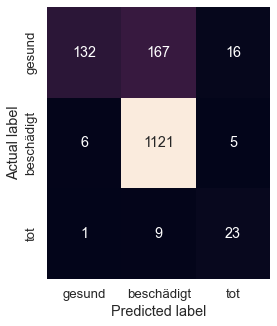


Deciduous
	F1 Score: 0.8280722783916762
	Cohen Kappa Score: 0.65421936433538
              precision    recall  f1-score   support

     damaged       0.94      1.00      0.97       474
        dead       1.00      0.75      0.86         4
     healthy       0.94      0.51      0.66        63

    accuracy                           0.94       541
   macro avg       0.96      0.75      0.83       541
weighted avg       0.94      0.94      0.93       541



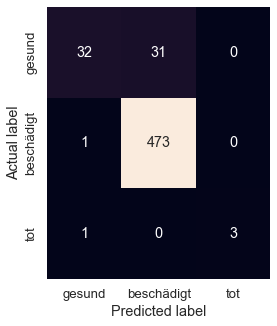


Mixed
	F1 Score: 0.7448692810457516
	Cohen Kappa Score: 0.5773822933093038
              precision    recall  f1-score   support

     damaged       0.93      1.00      0.96       773
        dead       1.00      0.50      0.67         4
     healthy       0.98      0.44      0.60        94

    accuracy                           0.94       871
   macro avg       0.97      0.64      0.74       871
weighted avg       0.94      0.94      0.92       871



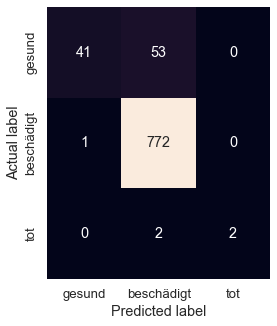

In [17]:
for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]):
    print(f"{species}")
    df_test = data[SPECIES_inverse[species]]['test']
    
    def cascade_results(pred_dead, pred_healthy, pred_damaged):
        if pred_dead == 1:
            return "dead"
        elif pred_healthy == 1:
            return "healthy"
        else:
            return "damaged"

    df_test["cascaded_prediction"] = df_test.apply(lambda x: cascade_results(x["is_dead_pred"], x["is_healthy_pred"], x["is_damaged_pred"]), axis=1)
    
    #tn, fp, fn, tp = metrics.confusion_matrix(df_test["damage_class_group"], df_test["cascaded_prediction"]).ravel()
    #print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
    print(f"\tF1 Score: {metrics.f1_score(df_test['damage_class_group'], df_test['cascaded_prediction'], average='macro')}")
    print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(df_test['damage_class_group'], df_test['cascaded_prediction'])}")
    print(metrics.classification_report(df_test['damage_class_group'], df_test['cascaded_prediction']))
    
    sns.set(font_scale=1.2)
    
    labels = ['healthy','damaged','dead']
    labels_translated = ['gesund', 'beschädigt', 'tot']
    cm = metrics.confusion_matrix(df_test['damage_class_group'], df_test['cascaded_prediction'], labels=labels)
    plt.figure(figsize=(4,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, yticklabels=labels_translated, xticklabels=labels_translated)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    #plt.savefig(f'./IMAGES/{species}_cascaded_prediction.eps', format='eps', bbox_inches="tight")  
    
    plt.show()
    
    print()

In [18]:
# based on tree distribution in Blackforest (from thuenen)
weights = {
    "Conifer": 0.72,
    "Deciduous": 0.28,
}

df_weighted_metrics = list()
df_weighted_metrics_mixed = list()


_f1 = metrics.f1_score(data[SPECIES_inverse[species]]['test']['damage_class_group'], data[SPECIES_inverse[species]]['test']['cascaded_prediction'], average='macro')
_cp = metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['test']['damage_class_group'], data[SPECIES_inverse[species]]['test']['cascaded_prediction'])

for species in weights.keys():
    df_test = data[SPECIES_inverse[species]]['test']
    df_test["cascaded_prediction"]
    
    f1 = metrics.f1_score(df_test['damage_class_group'], df_test['cascaded_prediction'], average='macro')
    cp = metrics.cohen_kappa_score(df_test['damage_class_group'], df_test['cascaded_prediction'])
    
    df_weighted_metrics.append({
        "f1":f1,
        "cp":cp,
        "species": species,
        "weight": weights[species]
    })
    
df_weighted_metrics = pd.json_normalize(df_weighted_metrics)

for group, df_group in df_weighted_metrics.groupby("species"):
    print('#'*29)
    print(f'{group}')
    print(f'\t> F1-Score:\t{round(np.average(df_group["f1"], weights = df_group["weight"]),3)}')
    print(f'\t> Cohens Kappa:\t{round(np.average(df_group["cp"], weights = df_group["weight"]),3)}')

print('#'*29)

print()

print('#'*29)
print(f'\t> F1-Score:\t{round(np.average(df_weighted_metrics["f1"], weights = df_weighted_metrics["weight"]),3)}')
print(f'\t> Cohens Kappa:\t{round(np.average(df_weighted_metrics["cp"], weights = df_weighted_metrics["weight"]),3)}')
print('#'*29)

#############################
Conifer
	> F1-Score:	0.701
	> Cohens Kappa:	0.554
#############################
Deciduous
	> F1-Score:	0.828
	> Cohens Kappa:	0.654
#############################

#############################
	> F1-Score:	0.736
	> Cohens Kappa:	0.582
#############################


#### Export Meta-Models

In [21]:
df_relevant_fitted_models.to_csv(f"{EXPORT_PATH}/relevant_features_damage_class_groups.csv", index=False)

In [19]:
df_relevant_fitted_models = pd.read_csv(f"{EXPORT_PATH}/relevant_features_damage_class_groups.csv")
df_relevant_fitted_models["features"] = df_relevant_fitted_models["features"].apply(literal_eval)
df_relevant_fitted_models["predictions"] = df_relevant_fitted_models["predictions"].apply(literal_eval)

def rename_path(path):
    return path.replace("./results/FINAL/", EXPORT_PATH)

df_relevant_fitted_models["file"] = df_relevant_fitted_models["file"].apply(rename_path)

df_relevant_fitted_models_reindex = df_relevant_fitted_models.set_index(["species", "target"]).sort_values(by=["species", "target"])
df_relevant_fitted_models_reindex

name source  \
species   target                                              
Conifer   is_damaged          DecisionTreeClassifier     v2   
          is_damaged              RUSBoostClassifier     v5   
          is_damaged                   XGBClassifier     v2   
          is_damaged              AdaBoostClassifier     v1   
          is_dead               KNeighborsClassifier     v2   
          is_dead     HistGradientBoostingClassifier     v5   
          is_dead                 RUSBoostClassifier     v1   
          is_healthy          RandomForestClassifier     v1   
          is_healthy              RUSBoostClassifier     v2   
          is_healthy              AdaBoostClassifier     v1   
Deciduous is_damaged  BalancedRandomForestClassifier     v2   
          is_damaged                             SVM     v5   
          is_damaged              RUSBoostClassifier     v1   
          is_dead     HistGradientBoostingClassifier     v2   
          is_dead                                SVM     v2   
          is_dead               KNeighborsClassifier     v2   
          is_healthy          RandomForestClassifier     v1   
          is_healthy  BalancedRandomForestClassifier     v1   
          is_healthy              RUSBoostClassifier     v2   
Mixed     is_damaged          DecisionTreeClassifier     v5   
          is_damaged                             SVM     v1   
          is_damaged                   XGBClassifier     v5   
          is_damaged              RUSBoostClassifier     v1   
          is_damaged  HistGradientBoostingClassifier     v1   
          is_damaged          RandomForestClassifier     v1   
          is_damaged  BalancedRandomForestClassifier     v1   
          is_dead     HistGradientBoostingClassifier     v1   
          is_dead               KNeighborsClassifier     v2   
          is_dead                 AdaBoostClassifier     v5   
          is_healthy          DecisionTreeClassifier     v1   
          is_healthy  BalancedRandomForestClassifier     v1   
          is_healthy                   XGBClassifier     v5   

                                                               features  \
species   target                                                          
Conifer   is_damaged  [location_cluster_0, location_cluster_3, locat...   
          is_damaged  [location_cluster_1, location_cluster_4, locat...   
          is_damaged  [location_cluster_1, location_cluster_6, locat...   
          is_damaged  [location_cluster_3, location_cluster_4, locat...   
          is_dead     [location_cluster_4, location_cluster_13, tree...   
          is_dead     [location_cluster_5, location_cluster_10, loca...   
          is_dead     [location_cluster_1, location_cluster_4, locat...   
          is_healthy  [location_cluster_2, location_cluster_5, locat...   
          is_healthy  [location_cluster_4, location_cluster_5, locat...   
          is_healthy  [location_cluster_4, location_cluster_5, locat...   
Deciduous is_damaged  [location_cluster_0, location_cluster_3, locat...   
          is_damaged  [location_cluster_0, location_cluster_1, locat...   
          is_damaged  [location_cluster_0, location_cluster_1, locat...   
          is_dead     [location_cluster_4, location_cluster_10, tree...   
          is_dead     [tree_1, evi2_diff, evi2_max_diff, evi2_vegeta...   
          is_dead     [location_cluster_4, location_cluster_5, locat...   
          is_healthy  [location_cluster_2, location_cluster_5, locat...   
          is_healthy  [location_cluster_0, location_cluster_1, locat...   
          is_healthy  [location_cluster_0, location_cluster_1, locat...   
Mixed     is_damaged  [tree_1, evi2_raster, evi2_raster_diff, evi2_v...   
          is_damaged  [location_cluster_0, location_cluster_5, locat...   
          is_damaged  [location_cluster_0, location_cluster_2, locat...   
          is_damaged  [location_cluster_4, location_cluster_5, locat...   
          is_damaged  [locatio

#### Inspect Details

In [20]:
import geopandas as gpd
df_wze = gpd.read_file("./data/wze_observations.geojson")
df_wze = df_wze.loc[df_wze["year"] >= 2015]
df_wze

,id,year,tree_age,nbv_perc,damage_class,sat,id_tree,bhd,damage_class_group,tree_sp_fam,tree_sp_cat_id,tree_sp_id,tree_sp_fam_id,x,y,sdi,tree_area_m2,tree_width,geometry
0,SH_10003,2015,139.0,30.0,2.0,na,SH_10003_36,411.578674,damaged,Fichte,2,214,208,595422.931867,5.940904e+06,203.206210,49.211094,7.015062,POINT (595422.932 5940904.097)
1,SH_10003,2015,139.0,35.0,2.0,na,SH_10003_35,398.321686,damaged,Fichte,2,214,208,595422.931867,5.940904e+06,214.583956,46.601807,6.826552,POINT (595422.932 5940904.097)
2,SH_10003,2015,149.0,20.0,1.0,na,SH_10003_34,536.760498,damaged,Buche,1,229,102,595422.931867,5.940904e+06,79.397923,125.947879,11.222650,POINT (595422.932 5940904.097)
3,SH_10003,2015,139.0,10.0,0.0,na,SH_10003_33,513.889893,healthy,Kiefer,2,215,209,595422.931867,5.940904e+06,185.767831,53.830633,7.336936,POINT (595422.932 5940904.097)
4,SH_10003,2015,139.0,30.0,2.0,na,SH_10003_32,411.578674,damaged,Fichte,2,214,208,595422.931867,5.940904e+06,203.206210,49.211094,7.015062,POINT (595422.932 5940904.097)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92737,NI_30672,2020,50.0,10.0,0.0,na,NI_30672_4301,420.515350,healthy,Buche,1,229,102,611723.078880,5.717476e+06,122.868570,81.387779,9.021518,POINT (611723.079 5717476.117)
92738,NI_30672,2020,50.0,0.0,0.0,na,NI_30672_4401,448.933929,healthy,Buche,1,229,102,611723.078880,5.717476e+06,109.303023,91.488778,9.564977,POINT (611723.079 5717476.117)
92739,NI_30672,2020,50.0,5.0,0.0,na,NI_30672_4501,471.278290,healthy,Buche,1,229,102,611723.078880,5.717476e+06,100.205882,99.794541,9.989722,POINT (611723.079 5717476.117)
92740,NI_30672,2020,50.0,0.0,0.0,na,NI_30672_4601,448.933929,healthy,Buche,1,229,102,611723.078880,5.717476e+06,109.303023,91.488778,9.564977,POINT (611723.079 5717476.117)


## Explainable AI
### Analyze: Usage of Attributes

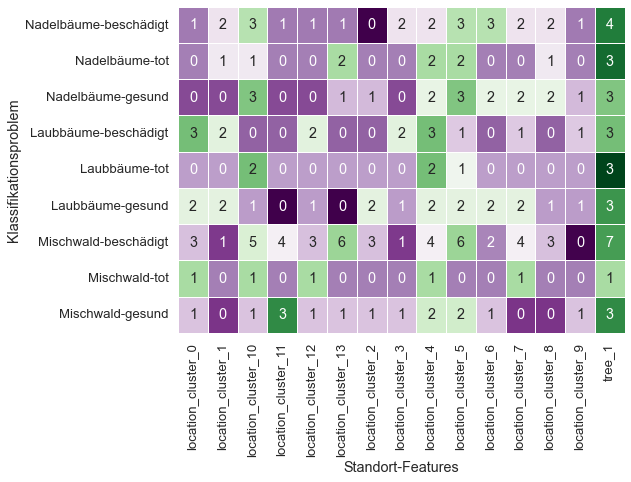

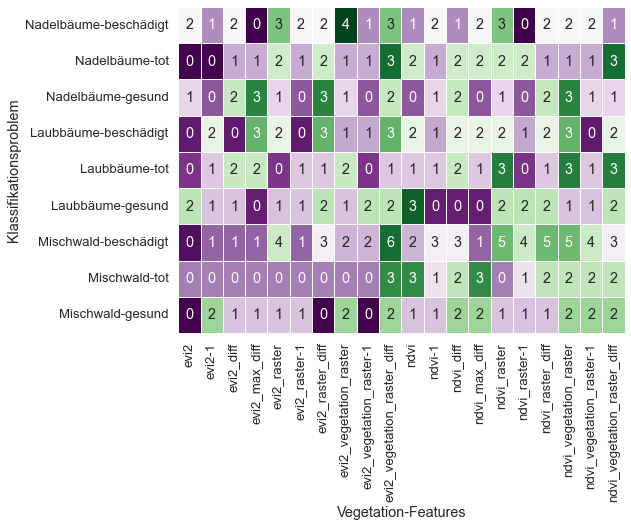

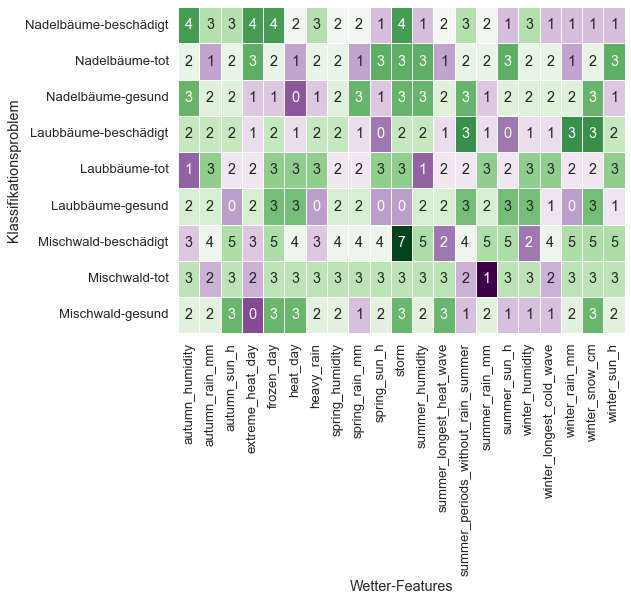

In [27]:
# column groups
location_cols = [
    'location_cluster_0', 'location_cluster_1', 'location_cluster_2', 'location_cluster_3', 'location_cluster_4', 'location_cluster_5', 'location_cluster_6', 'location_cluster_7', 'location_cluster_8', 
    'location_cluster_9', 'location_cluster_10', 'location_cluster_11', 'location_cluster_12', 'location_cluster_13',
    'tree_1'
]

weather_cols = [
    'winter_humidity', 'winter_longest_cold_wave', 'winter_rain_mm', 'winter_snow_cm', 'winter_sun_h',
    'spring_humidity', 'spring_rain_mm', 'spring_sun_h', 
    'storm', 'extreme_heat_day', 'frozen_day', 'heat_day', 'heavy_rain',
    'summer_humidity', 'summer_longest_heat_wave', 'summer_periods_without_rain_summer', 'summer_rain_mm', 'summer_sun_h',
    'autumn_humidity', 'autumn_rain_mm', 'autumn_sun_h',
]

vegetation_cols = [
    'ndvi', 'ndvi-1', 'ndvi_diff', 'ndvi_max', 'ndvi_max_diff', 'ndvi_raster','ndvi_raster-1', 'ndvi_raster_diff', 'ndvi_vegetation_raster', 'ndvi_vegetation_raster-1', 'ndvi_vegetation_raster_diff',
     'evi2', 'evi2-1', 'evi2_diff', 'evi2_max', 'evi2_max_diff', 'evi2_raster', 'evi2_raster-1', 'evi2_raster_diff', 'evi2_vegetation_raster', 'evi2_vegetation_raster-1', 'evi2_vegetation_raster_diff',
]

feature_occurances = df_relevant_fitted_models_reindex.explode("features").reset_index().groupby(["species", "target", "features"]).size().reset_index().rename(columns={0: "count"})
feature_occurances = feature_occurances.pivot(columns="features", values="count", index=["species", "target"]).fillna(0)
feature_occurances = feature_occurances.rename({"Conifer":"Nadelbäume", "Deciduous": "Laubbäume", "Mixed": "Mischwald", "is_damaged": "beschädigt", "is_dead": "tot", "is_healthy": "gesund"})

feature_occurances.reset_index().to_csv(f"{EXPORT_PATH}/feature_occurances_group.csv", index=False)

sns.set(font_scale=1.2)

for col in feature_occurances.columns:
    feature_occurances[col] = feature_occurances[col].astype(int)

groups = dict(
    Standort=[col for col in feature_occurances.columns if "location" in col or "tree" in col],
    Vegetation=[col for col in feature_occurances.columns if "ndvi" in col or "evi" in col],
    Wetter=[col for col in feature_occurances.columns if "location" not in col and "tree" not in col and "ndvi" not in col and "evi" not in col]
)

for i, group in enumerate(groups.keys()):
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

    # normalize by row
    df_norm_row = feature_occurances[groups[group]].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    # normalize by column
    df_norm_col=(feature_occurances[groups[group]]-feature_occurances[groups[group]].mean())/feature_occurances[groups[group]].std()
    
    ax = sns.heatmap(df_norm_row, annot=feature_occurances[groups[group]], fmt="d", ax=axes, cmap="PRGn", linewidths=.5, cbar=False) #
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_xlabel(f"{group}-Features")
    ax.set_ylabel(f"Klassifikationsproblem")
    
    #plt.savefig(f'./{group}_feature_occurances_group.eps', format='eps', bbox_inches="tight")  
    plt.show()


### Used Models

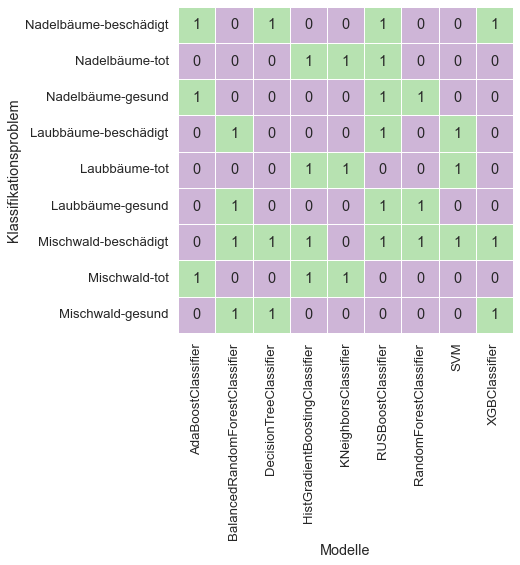

In [94]:
model_occurances = df_relevant_fitted_models_reindex.reset_index().groupby(["species", "target", "name"]).size().reset_index().rename(columns={0: "count"})
model_occurances = model_occurances.pivot(columns="name", values="count", index=["species", "target"]).fillna(0)
model_occurances = model_occurances.rename({"Conifer":"Nadelbäume", "Deciduous": "Laubbäume", "Mixed": "Mischwald", "is_damaged": "beschädigt", "is_dead": "tot", "is_healthy": "gesund"})

model_occurances.reset_index().to_csv("./model_occurances_group.csv", index=False)

for col in model_occurances.columns:
    model_occurances[col] = model_occurances[col].astype(int)

fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

ax = sns.heatmap(model_occurances, annot=True, fmt="d", ax=axes, cmap="PRGn", linewidths=.5, cbar=False, vmin=-1, vmax=2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
ax.set_xlabel(f"Modelle")
ax.set_ylabel(f"Klassifikationsproblem")
    
#plt.savefig(f'./used_models_group.eps', format='eps', bbox_inches="tight")
plt.show()

In [28]:
with open(f"{EXPORT_PATH}/permutation_importances.json", "r") as f:
    permutation_importance = json.load(f)
    
df_permutation_importance = pd.json_normalize(permutation_importance, max_level=0)
df_permutation_importance[["feature", "permuation_importance"]] = df_permutation_importance["permutation_importances"].apply(lambda x: pd.Series([list(x.keys()), list(x.values())]))
df_permutation_importance.drop(columns="permutation_importances", inplace=True)
df_permutation_importance = df_permutation_importance.explode(["feature", "permuation_importance"])
df_permutation_importance = df_permutation_importance.sort_values(by="feature")

def apply_feature_group(feature: str):
    for group in groups.keys():
        if feature in groups[group]:
            return group

df_permutation_importance["Feature Kategorie"] = df_permutation_importance["feature"].apply(apply_feature_group)

df_permutation_importance_filter = df_permutation_importance.groupby("feature").agg({"permuation_importance": "mean"}).reset_index()
df_permutation_importance_filter = df_permutation_importance_filter.loc[df_permutation_importance_filter["permuation_importance"] > 0.01]

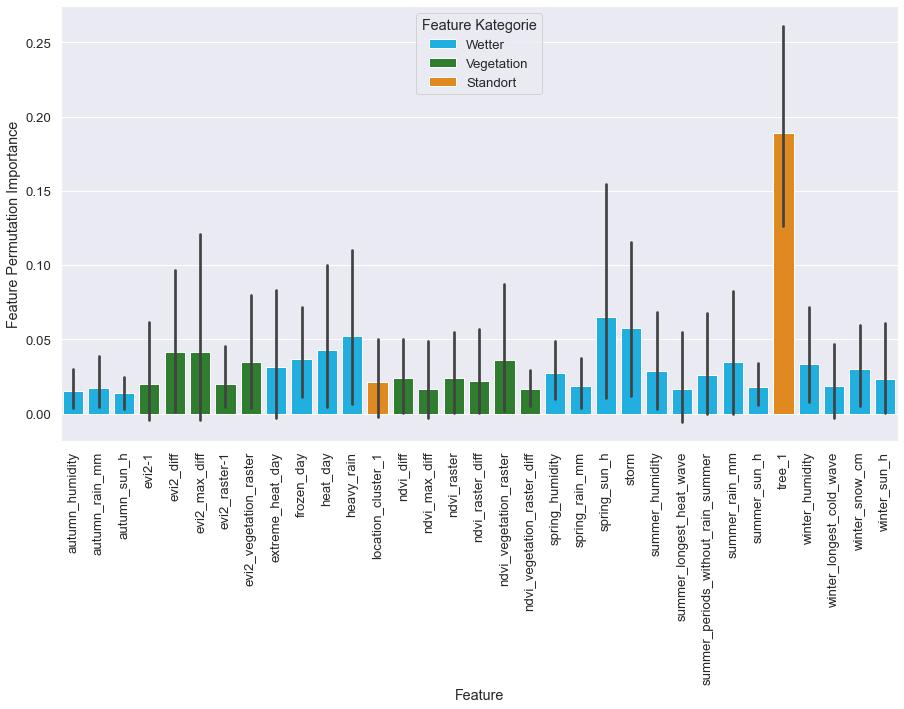

In [29]:
fig, axes = plt.subplots(figsize=(15, 8))
palette = {"Wetter": "deepskyblue", "Standort": "darkorange", "Vegetation": "forestgreen"}
ax = sns.barplot(data=df_permutation_importance.loc[df_permutation_importance["feature"].isin(list(df_permutation_importance_filter["feature"].unique()))], x="feature", y="permuation_importance", hue="Feature Kategorie", palette=palette, dodge=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xlabel(f"Feature")
ax.set_ylabel(f"Feature Permutation Importance")

#plt.savefig(f'./IMAGES/feature_permutation_importance_filtered.eps', format='eps', bbox_inches="tight")

plt.show()

## Validate

Validate Meta-Models by using validation dataset and vote prediction
### Predict Using Meta-Models

In [ ]:
master_models = dict()
validation_predictions = dict()

# put models in place
for species in df_relevant_fitted_models["species"].unique():
    master_models[species] = dict()
    validation_predictions[species] = dict()
    
    for target in df_relevant_fitted_models["target"].unique():
        master_models[species][target] = list()

        validation_predictions[species][target] = dict(
            single=list(),
            voted=list()
        )
         
        df_sel = df_relevant_fitted_models.loc[(df_relevant_fitted_models["species"] == species) & (df_relevant_fitted_models["target"] == target)]

        for _i, model_row in df_sel.iterrows():
            master_models[species][target].append(dict(
                #model= pickle.load(open(model_row["file"], "rb")),
                file=model_row["file"],
                threshold=model_row["threshold"],
                weight=model_row["cohen_kappa"],
                features=model_row["features"],
            ))
            
            y_pred_proba = pickle.load(open(model_row["file"], "rb")).predict_proba(data[SPECIES_inverse[species]]["validation"][model_row["features"]])
            pred = apply_prediction(y_pred_proba[:, 1], model_row["threshold"])
            validation_predictions[species][target]["single"].append(pred)


In [33]:
# voting
for target in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 0]): # df_relevant_fitted_models["target"].unique():
    for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]): # df_relevant_fitted_models["species"].unique():
        print(f"{target} -> {species}")
        
        weights = list()
        voted_preds = np.zeros(data[SPECIES_inverse[species]]["validation"].shape[0])

        for i, model_pred in enumerate(validation_predictions[species][target]["single"]):
            voted_preds += np.array(model_pred) * master_models[species][target][i]["weight"]
            weights.append(master_models[species][target][i]["weight"])

        sum_weights = np.array(weights).sum()

        result = np.where(voted_preds >= sum_weights/(len(weights)/2), 1, 0)
        
        validation_predictions[species][target]["voted"] = result.tolist()
        
        try:
            tn, fp, fn, tp = metrics.confusion_matrix(data[SPECIES_inverse[species]]["validation"][target].values, result).ravel()
            print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
        except ValueError:
            print(metrics.confusion_matrix(data[SPECIES_inverse[species]]["validation"][target].values, result))
        print(f"\tF1 Score: {metrics.f1_score(data[SPECIES_inverse[species]]['validation'][target].values, result, average='binary')}")
        print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(data[SPECIES_inverse[species]]['validation'][target].values, result)}")
        print()
        
        data[SPECIES_inverse[species]]['validation'][f"{target}_pred"] = result
        
    print("-"*50)

is_damaged -> Conifer
	tn: 0, fp: 195, fn: 0, tp: 565
	F1 Score: 0.8528301886792453
	Cohen Kappa Score: 0.0

is_damaged -> Deciduous
	tn: 0, fp: 28, fn: 0, tp: 448
	F1 Score: 0.9696969696969697
	Cohen Kappa Score: 0.0

is_damaged -> Mixed
	tn: 0, fp: 41, fn: 0, tp: 468
	F1 Score: 0.9580348004094166
	Cohen Kappa Score: 0.0

--------------------------------------------------
is_dead -> Conifer
	tn: 732, fp: 0, fn: 9, tp: 19
	F1 Score: 0.8085106382978724
	Cohen Kappa Score: 0.8026315789473684

is_dead -> Deciduous
[[476]]
	F1 Score: 0.0
	Cohen Kappa Score: nan

is_dead -> Mixed
	tn: 507, fp: 0, fn: 2, tp: 0
	F1 Score: 0.0
	Cohen Kappa Score: 0.0

--------------------------------------------------
is_healthy -> Conifer
	tn: 562, fp: 31, fn: 141, tp: 26
	F1 Score: 0.23214285714285715
	Cohen Kappa Score: 0.13546117114852974

is_healthy -> Deciduous
	tn: 444, fp: 4, fn: 24, tp: 4
	F1 Score: 0.22222222222222224
	Cohen Kappa Score: 0.20134228187919467

is_healthy -> Mixed
	tn: 468, fp: 2, fn: 3

### Analyze Results

Conifer
	F1 Score: 0.6319125208981776
	Cohen Kappa Score: 0.2403735179939146
              precision    recall  f1-score   support

     damaged       0.78      0.95      0.86       565
        dead       1.00      0.68      0.81        28
     healthy       0.46      0.16      0.23       167

    accuracy                           0.76       760
   macro avg       0.75      0.59      0.63       760
weighted avg       0.72      0.76      0.72       760



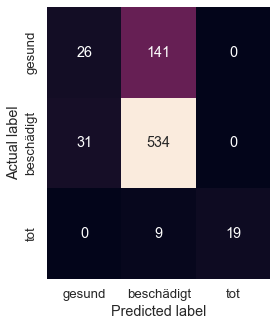


Deciduous
	F1 Score: 0.5958272683163514
	Cohen Kappa Score: 0.20134228187919467
              precision    recall  f1-score   support

     damaged       0.95      0.99      0.97       448
     healthy       0.50      0.14      0.22        28

    accuracy                           0.94       476
   macro avg       0.72      0.57      0.60       476
weighted avg       0.92      0.94      0.93       476



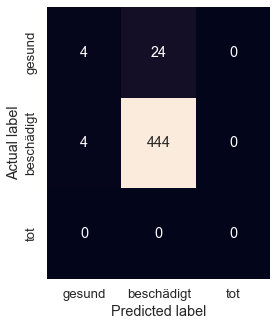


Mixed
	F1 Score: 0.379204333066331
	Cohen Kappa Score: 0.15322271040395852
              precision    recall  f1-score   support

     damaged       0.93      1.00      0.96       468
        dead       0.00      0.00      0.00         2
     healthy       0.67      0.10      0.18        39

    accuracy                           0.92       509
   macro avg       0.53      0.37      0.38       509
weighted avg       0.90      0.92      0.90       509



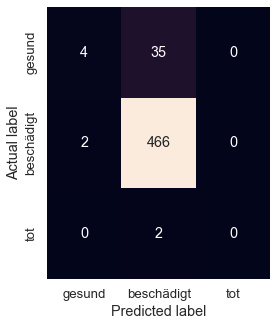

In [34]:
for species in np.unique(np.array([[str(i[0]), str(i[1])] for i in df_relevant_fitted_models_grouped.index])[:, 1]):
    print(f"{species}")
    df_val = data[SPECIES_inverse[species]]['validation']
    
    def cascade_results(pred_dead, pred_healthy, pred_damaged):
        if pred_dead == 1:
            return "dead"
        elif pred_healthy == 1:
            return "healthy"
        else:
            return "damaged"
        
    df_val["cascaded_prediction"] = df_val.apply(lambda x: cascade_results(x["is_dead_pred"], x["is_healthy_pred"], x["is_damaged_pred"]), axis=1)
    
    #tn, fp, fn, tp = metrics.confusion_matrix(df_val["damage_class_group"], df_val["cascaded_prediction"]).ravel()
    #print(f"\ttn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}")
    print(f"\tF1 Score: {metrics.f1_score(df_val['damage_class_group'], df_val['cascaded_prediction'], average='macro')}")
    print(f"\tCohen Kappa Score: {metrics.cohen_kappa_score(df_val['damage_class_group'], df_val['cascaded_prediction'])}")
    print(metrics.classification_report(df_val['damage_class_group'], df_val['cascaded_prediction']))
    
    sns.set(font_scale=1.2)
    
    labels = ['healthy','damaged','dead']
    labels_translated = ['gesund', 'beschädigt', 'tot']
    cm = metrics.confusion_matrix(df_val['damage_class_group'], df_val['cascaded_prediction'], labels=labels)
    plt.figure(figsize=(4,5))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, yticklabels=labels_translated, xticklabels=labels_translated)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    #plt.savefig(f'./{species}_cascaded_prediction_validation.eps', format='eps', bbox_inches="tight")  
    
    plt.show()
    
    print()

In [83]:
# parse numpy array to array for json export
for species in validation_predictions:
    for target in validation_predictions[species]:
        for i, item in enumerate(validation_predictions[species][target]["single"]):
            if isinstance(validation_predictions[species][target]["single"][i], np.ndarray):
                validation_predictions[species][target]["single"][i] = item.tolist()

In [84]:
with open(f"{EXPORT_PATH}/validation_predictions.json", "w") as fp:
    json.dump(validation_predictions, fp)

In [120]:
with open(f"{EXPORT_PATH}/master_models.json", "w") as fp:
    json.dump(master_models, fp)

In [31]:
with open(f"{EXPORT_PATH}/master_models.json") as fp:
    master_models = json.loads(fp.read())

In [32]:
with open(f"{EXPORT_PATH}/validation_predictions.json") as fp:
    validation_predictions = json.loads(fp.read())

In [ ]:
# generate pred column from json export
for species in validation_predictions:
    for target in validation_predictions[species]:
        data[SPECIES_inverse[species]]["validation"][f"{target}_pred"] = validation_predictions[species][target]["voted"]

data[SPECIES_inverse[species]]["validation"]